In [1]:
# You must install this system library to make pylibdmtx work
# sudo apt-get install libdmtx0b

In [2]:
from PIL import Image
import pylibdmtx.pylibdmtx
import albumentations
import numpy as np
import pandas as pd

In [3]:
encoded = pylibdmtx.pylibdmtx.encode('Máme rádi papoušky'.encode('utf8'))
img = Image.frombytes('RGB', (encoded.width, encoded.height), encoded.pixels)
img.save('dmtx.png')
decoded = pylibdmtx.pylibdmtx.decode(Image.open('dmtx.png'))
decoded[0].data.decode("utf8")

'Máme rádi papoušky'

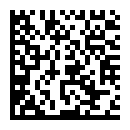

In [4]:
img

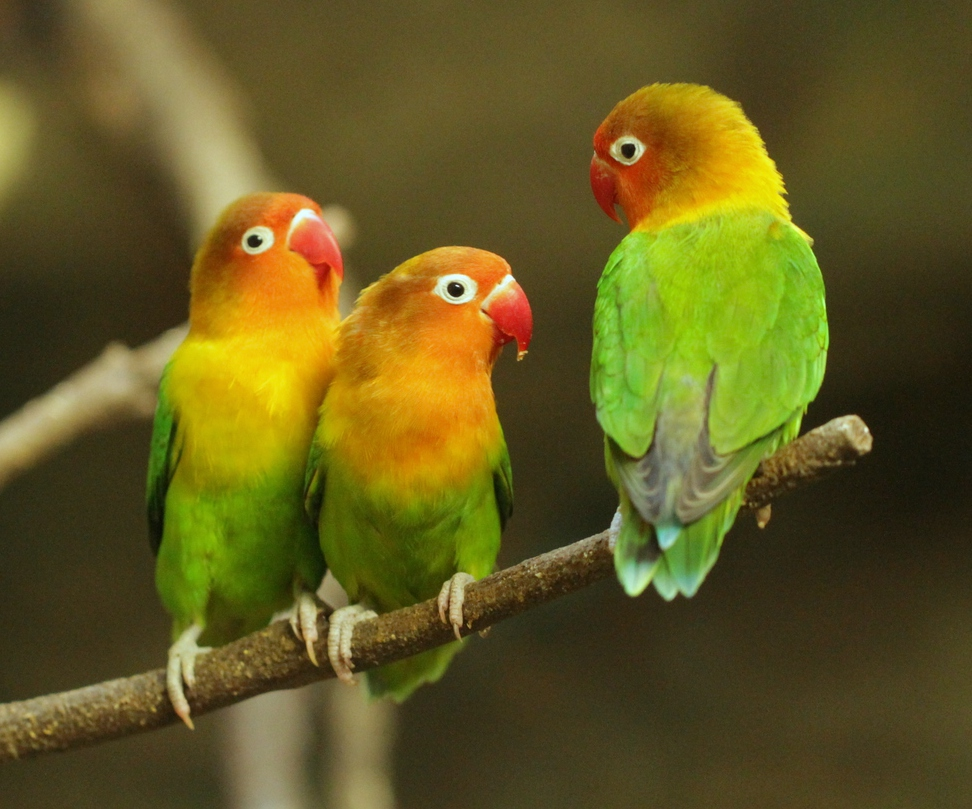

In [5]:
image = Image.open("parrot.jpg")
image

In [6]:
transform = albumentations.Compose([
    albumentations.RandomCrop(width=256, height=256),
    albumentations.HorizontalFlip(p=0.5),
    albumentations.RandomBrightnessContrast(p=0.2),
])

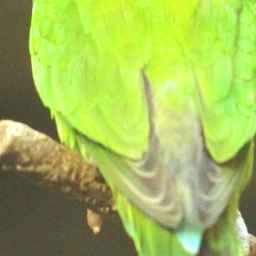

In [7]:
transformed = transform(image=np.array(image))
transformed_image = transformed["image"]
Image.fromarray(transformed_image)

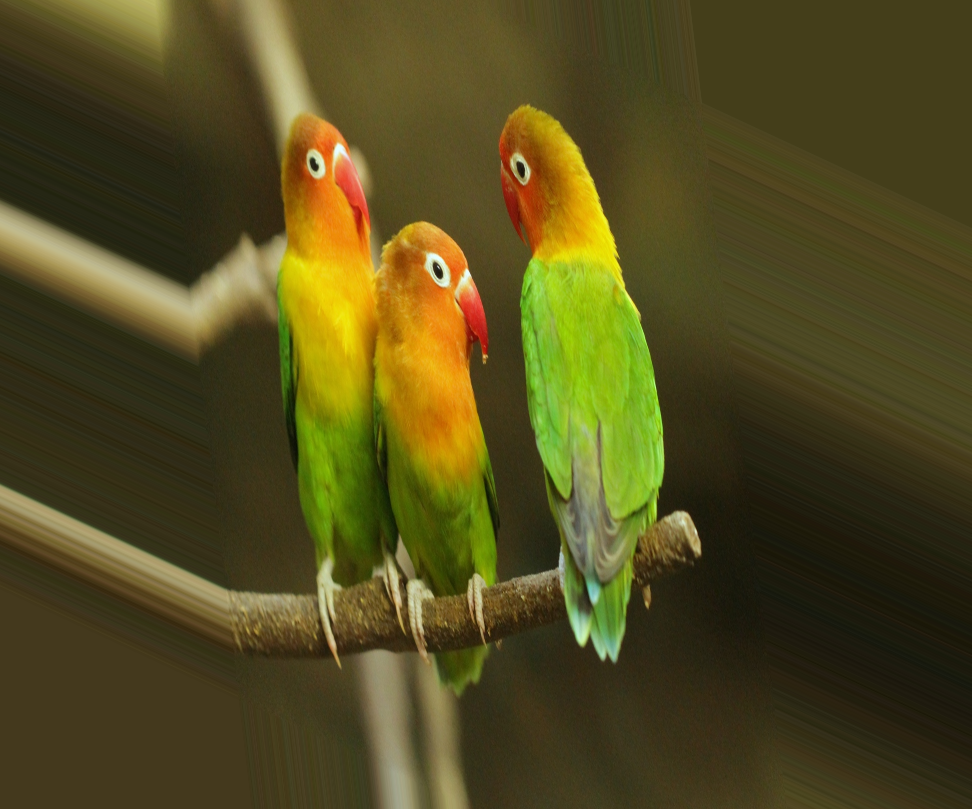

In [8]:
el_transform = albumentations.ElasticTransform(always_apply=True, alpha_affine=200, border_mode=1)
el_transformed = el_transform(image=np.array(image))
el_transformed_image = el_transformed["image"]
Image.fromarray(el_transformed_image)

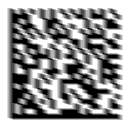

In [9]:
blur_transform = albumentations.MotionBlur(always_apply=True)
blur_transformed = blur_transform(image=np.array(img))
blur_transformed_image = blur_transformed["image"]
Image.fromarray(blur_transformed_image)

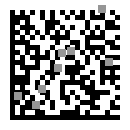

In [10]:
drop_transform = albumentations.CoarseDropout(always_apply=True, fill_value=150)
drop_transformed = drop_transform(image=np.array(img))
drop_transformed_image = drop_transformed["image"]
Image.fromarray(drop_transformed_image)

In [11]:
import conv_ae
import datamatrix_provider as dmp

/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


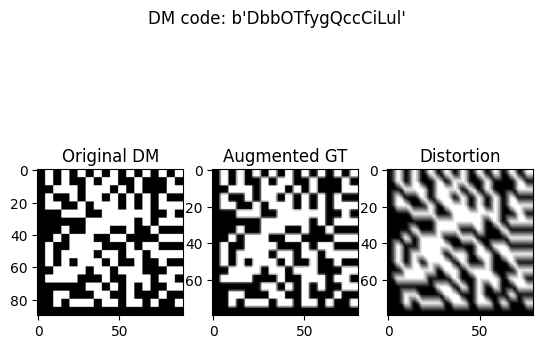

In [12]:
dm_provider = dmp.DataMatrixProvider(visualize=True)
dm_generate, dm_size, dm_mode, dm_mode_opts, dm_const = dm_provider.init_dm_provider(library="pylibdmtx", pylibdmtx_params={})
dm_clean, dm_augm, dm_text = dm_generate()

In [13]:
import random

def create_dataset(num_samples, seed=0):
    random.seed(seed)
    dataset = []
    dm_provider = dmp.DataMatrixProvider()
    for _ in range(num_samples):
        dm_clean, dm_augm, dm_text = next(dm_provider)[0]
        dataset.append((dm_clean, dm_augm, dm_text))
    return pd.DataFrame(dataset, columns=["target", "corrupted", "text"])

In [14]:
import torch

class MyMapDataset(torch.utils.data.Dataset):
    def __init__(self, dataset) -> None:
        super().__init__()
        self.dataset = dataset

    def __len__(self) -> int:
        return len(self.dataset)

    def __getitem__(self, i: int) -> dict:
        return {"target": self.dataset.iloc[i]["target"],
                "corrupted": self.dataset.iloc[i]["corrupted"]}

In [15]:
dataloader_valid = torch.utils.data.DataLoader(dataset=MyMapDataset(create_dataset(500)), batch_size=64)
dataloader_test = torch.utils.data.DataLoader(dataset=MyMapDataset(create_dataset(500)), batch_size=64)

In [16]:
next(iter(dataloader_valid))

/home/kp/miniconda3/envs/dm-codes/lib/python3.9/site-packages/torch/utils/data/_utils/collate.py:172: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:199.)
  return collate([torch.as_tensor(b) for b in batch], collate_fn_map=collate_fn_map)


{'target': tensor([[[  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]],
 
         [[  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]],
 
         [[  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          [  0,   0,   0,  ..., 255, 255, 255],
          ...,
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0],
          [  0,   0,   0,  ...,   0,   0,   0]],
 
         ...,
 
         [[  0,   0,   0,  ..., 255, 255, 255],
        

In [18]:
import torch

class MyMapDataset(torch.utils.data.Dataset):
    def __init__(self, ...) -> None:
        super().__init__()
        ...

    def __len__(self) -> int:
        ...

    def __getitem__(self, i: int) -> dict:
        ...


class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, ...) -> None:
        super().__init__()
        ...

    def __iter__(self):
        return self
    
    def __next__(self) -> dict:
        ...


class MyIterableDataset(torch.utils.data.IterableDataset):
    def __init__(self, ...) -> None:
        super().__init__()
        ...

    def __iter__(self):
        ...
        for _ in ...:
            yield ...

SyntaxError: invalid syntax (610515905.py, line 6)